# TITLE

# Introduction

To fill

<div style="border-left: 6px solid rgba(69, 157, 185, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(69, 157, 185, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">Analysis</p>
    <div style="padding: 0 0 2px 10px;">
    
**What will be covered :**
- **Part 1 :** Using LDA on the synopsis dataset
- **Part 2 :** Analysis of the movie dataset
- **Part 3 :** Analysis of the historical dataset

</div></div>
<br/>

---

# Part 1: Using LDA on the synopsis dataset

### Import libraries

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.ticker as mtick
# LDA
# gensim is a popular library for topic modelling
# nltk.download('punkt')
# nltk.download('stopwords')
#from gensim.corpora import Dictionary
#from gensim.models import LdaModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from imdb import IMDb
import nltk
import re
import kagglehub # To extract synopsis dataframes
#import spacy




### Load initial movie dataset

In [26]:
movie_columnns =['Wikipedia movie ID','Freebase movie ID', 'Movie name', 'Movie release date', 'Movie box office revenue', 'Movie runtime', 'Movie languages', 'Movie countries', 'Movie genres']
movie = pd.read_csv('Data/movie.metadata.tsv', sep='\t', header=None, names=movie_columnns)
movie.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


### Comment
The cleaning and analyzing of this dataset will be done in Part. 2.

## Latent Dirichlet Allocation (LDA)
To group movies together based on something more precise than their genre, we will use Latent Dirichlet Allocation. LDA offers a way to cluster together movies that reflect similar themes, based on textual descriptions. The model is based on unsupervised learning, as the subjects are not known. However the movie summaries only give us too few informations to use LDA. That's why we will extract the synopsis of the movies through another dataset called "Movie Plot Synopses with Tags" (MPST). Those synopsis are around 10 times longer than the summaries, giving way more informations to the LDA model.

### Exploratory Data Analysis of Synopsis Dataframe

In [36]:
# Load data
synopsis = pd.read_csv('Data/mpst_full_data.csv')

# Check data shape
print("This synopsis dataframe is of size:", synopsis.shape)

# Display df
synopsis.head()

This synopsis dataframe is of size: (14828, 6)


,imdb_id,title,plot_synopsis,tags,split,synopsis_source
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb


### Comment
The dataframe offers extra movie tags and the full movie synopsis which would give the LDA more context to group movies together. On the other hand there a only 14'828 rows which is consequently smaller than the initial dataframe. We make the choice to reduce the dataset but gain precision on the themes generated by the LDA. Another important notice is that this dataframe uses imdb_id not wikipedia movie ids.

### Adding synopsis and tags to the initial movie df
To match the two dataset, we will merge by the name of the movies.

In [37]:
movies_syn = synopsis.merge(movie, left_on='title', right_on='Movie name', how='inner')
movies_syn.drop(columns=['title', 'split'], inplace=True)
movies_syn.head()

,imdb_id,plot_synopsis,tags,synopsis_source,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
0,tt1733125,"Two thousand years ago, Nhagruul the Foul, a s...",violence,imdb,30855958,/m/0gfjl1f,Dungeons & Dragons: The Book of Vile Darkness,2012-08-09,NaN,90.0,{},"{""/m/07ssc"": ""United Kingdom""}","{""/m/01hmnh"": ""Fantasy""}"
1,tt0033045,"Matuschek's, a gift store in Budapest, is the ...",romantic,imdb,76353,/m/0k4bt,The Shop Around the Corner,1940-01-12,NaN,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3nyp"": ..."
2,tt0113862,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",imdb,171076,/m/016z98,Mr. Holland's Opus,1995-12-29,106269971.0,130.0,"{""/m/02h40lc"": ""English Language"", ""/m/0my5"": ...","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3n84"": ""Inspirational Drama"", ""/m/0hqx..."
3,tt0086250,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",imdb,76331,/m/0k44g,Scarface,1932,NaN,94.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/0gw5w78"": ""G..."
4,tt0086250,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",imdb,267848,/m/01nln3,Scarface,1983-12-01,65884703.0,170.0,"{""/m/02h40lc"": ""English Language"", ""/m/06nm1"":...","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th..."


In [39]:
lost_rows = synopsis.shape[0] - movies_syn.shape[0]
print(f"We only lost {lost_rows} movies by merging the two dataset by the titles of the movies.")

We only lost 94 movies by merging the two dataset by the titles of the movies.


### Comment

1. Movie loss


The size fo the dataframe has not significantly changed, only 94 movies did not match. Our original movie df contained most of the movies present in the synopsis df.

2. Same title


We also observe that Scarface appears twice since there was a remake. For the rest for the analysis we will assume that if the name of the movie is exactly the same, the synopsis is pretty similar for both movies (if not the same!).

In [40]:
ratings_df = pd.read_csv('Data/title.ratings.tsv', sep='\t')

In [41]:
ratings_df = ratings_df.rename(columns={'tconst': 'imdb_id'})
movies_synopsis = pd.merge(movies_syn,ratings_df,on='imdb_id',how='inner')
movies_synopsis.head()

,imdb_id,plot_synopsis,tags,synopsis_source,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,averageRating,numVotes
0,tt1733125,"Two thousand years ago, Nhagruul the Foul, a s...",violence,imdb,30855958,/m/0gfjl1f,Dungeons & Dragons: The Book of Vile Darkness,2012-08-09,NaN,90.0,{},"{""/m/07ssc"": ""United Kingdom""}","{""/m/01hmnh"": ""Fantasy""}",4.4,2722
1,tt0033045,"Matuschek's, a gift store in Budapest, is the ...",romantic,imdb,76353,/m/0k4bt,The Shop Around the Corner,1940-01-12,NaN,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3nyp"": ...",8.0,39420
2,tt0113862,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",imdb,171076,/m/016z98,Mr. Holland's Opus,1995-12-29,106269971.0,130.0,"{""/m/02h40lc"": ""English Language"", ""/m/0my5"": ...","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3n84"": ""Inspirational Drama"", ""/m/0hqx...",7.3,42244
3,tt0086250,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",imdb,76331,/m/0k44g,Scarface,1932,NaN,94.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/0gw5w78"": ""G...",8.3,939605
4,tt0086250,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",imdb,267848,/m/01nln3,Scarface,1983-12-01,65884703.0,170.0,"{""/m/02h40lc"": ""English Language"", ""/m/06nm1"":...","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...",8.3,939605


## Can we observe new movies' groups using LDA?

### Preprocessing
Removing stop words and names before using LDA is important as those very frequent words are not used to predict themes + lowercase 

In [110]:
# This cell takes long to run you can use the movies_synopsis df instead

"""
# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

def remove_named_entities(text):
    doc = nlp(text)
    return ' '.join([token.text for token in doc if token.ent_type_ != "PERSON"])  # Exclude PERSON entities

stop_words = set(stopwords.words('english'))

# Sample movie summaries
sentences = movies_synopsis['plot_synopsis'].tolist()
print("Their are", len(sentences), "sentences")

# Remove names
cleaned_sentences= [remove_named_entities(doc) for doc in sentences]
print("After removing names their are", len(cleaned_sentences), "sentences")

# Remove stop words lowercase
processed_sentences = [
    [word for word in word_tokenize(sentence.lower()) if word.isalnum() and word not in stop_words]
    for sentence in cleaned_sentences
]
print("After total processing their are", len(processed_sentences), "sentences")

# stores processed_sentences in a df so that those steps do not have to be repeated
movies_synopsis['processed synopsis'] = processed_sentences
movies_synopsis.to_csv('movies_synopsis.csv', index=False)
"""


'\n# Load the spaCy model\nnlp = spacy.load("en_core_web_sm")\n\ndef remove_named_entities(text):\n    doc = nlp(text)\n    return \' \'.join([token.text for token in doc if token.ent_type_ != "PERSON"])  # Exclude PERSON entities\n\nstop_words = set(stopwords.words(\'english\'))\n\n# Sample movie summaries\nsentences = movies_synopsis[\'plot_synopsis\'].tolist()\nprint("Their are", len(sentences), "sentences")\n\n# Remove names\ncleaned_sentences= [remove_named_entities(doc) for doc in sentences]\nprint("After removing names their are", len(cleaned_sentences), "sentences")\n\n# Remove stop words lowercase\nprocessed_sentences = [\n    [word for word in word_tokenize(sentence.lower()) if word.isalnum() and word not in stop_words]\n    for sentence in cleaned_sentences\n]\nprint("After total processing their are", len(processed_sentences), "sentences")\n\n# stores processed_sentences in a df so that those steps do not have to be repeated\nmovies_synopsis[\'processed synopsis\'] = proces

In [111]:
# Create a dictionary and corpus for the LDA model
movies_synopsis = pd.read_csv('Data/movies_synopsis.csv')
processed_sentences = movies_synopsis['processed synopsis'].tolist()

FileNotFoundError: [Errno 2] No such file or directory: 'Data/movies_synopsis.csv'

In [ ]:
dictionary = Dictionary(processed_sentences)
corpus = [dictionary.doc2bow(sentence) for sentence in processed_sentences]

# Train LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, random_state=42, passes=10, iterations=50)

TypeError: doc2bow expects an array of unicode tokens on input, not a single string

In [ ]:
for topic_id, topic_words in lda_model.print_topics(num_words=15):
    print(f"Topic {topic_id}: {topic_words}")

Topic 0: 0.016*"police" + 0.008*"car" + 0.007*"man" + 0.007*"kill" + 0.007*"killed" + 0.007*"house" + 0.005*"finds" + 0.005*"dead" + 0.005*"gun" + 0.005*"one" + 0.005*"find" + 0.005*"body" + 0.005*"death" + 0.005*"murder" + 0.005*"shoots"
Topic 1: 0.005*"one" + 0.004*"war" + 0.004*"team" + 0.004*"men" + 0.003*"ship" + 0.003*"escape" + 0.003*"killed" + 0.003*"two" + 0.003*"attack" + 0.003*"world" + 0.003*"army" + 0.003*"earth" + 0.003*"group" + 0.003*"bomb" + 0.003*"time"
Topic 2: 0.022*"hamlet" + 0.018*"king" + 0.012*"macbeth" + 0.009*"claudius" + 0.006*"prince" + 0.006*"banquo" + 0.005*"act" + 0.005*"witches" + 0.005*"ghost" + 0.005*"queen" + 0.004*"castle" + 0.004*"musketeers" + 0.004*"father" + 0.004*"england" + 0.004*"love"
Topic 3: 0.007*"father" + 0.005*"love" + 0.005*"family" + 0.005*"one" + 0.005*"life" + 0.005*"new" + 0.005*"mother" + 0.004*"film" + 0.004*"home" + 0.004*"time" + 0.004*"also" + 0.004*"wife" + 0.003*"son" + 0.003*"later" + 0.003*"two"
Topic 4: 0.007*"back" + 0.0

This approcah seems promising! With very basic preprocessing can already interpret some themes:

*   Topic 0: Police + Kill -> Detective
*   Topic 1: War + team --> War
*   Topic 2: King + witches --> Medevial
*   Topic 3: Father + Love --> Family
*   Topic 4: Twon + Sherrif + Horse --> Western
*   Topic 5: Sea + treasure --> Pirate
*   Topic 6: Prince + Castle --> Fairy tale
*   Topic 7: Money + job --> Buisness
*   Topic 8: ?
*   Topic 9: ?


But we also observe that this still has room for improvement in example topics 9 still carries many names thus for further analysis the name removal step should be fine tuned. And also lemmatization should be applied to avoid reoccurences of declinaison of the same word (e.g killed and kill in topic 0)







passes: refers to the number of complete passes through the entire dataset. Increasing it gives the model more chances to learn the structure of your data.

iterations controls how many times the model iterates through each document per pass. Increasing iterations can help improve convergence for smaller datasets.

# Part 2: Analysis of the movie dataset

In [42]:
#Here comes the analysis
movies_synopsis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14686 entries, 0 to 14685
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   imdb_id                   14686 non-null  object 
 1   plot_synopsis             14686 non-null  object 
 2   tags                      14686 non-null  object 
 3   synopsis_source           14686 non-null  object 
 4   Wikipedia movie ID        14686 non-null  int64  
 5   Freebase movie ID         14686 non-null  object 
 6   Movie name                14686 non-null  object 
 7   Movie release date        14253 non-null  object 
 8   Movie box office revenue  5365 non-null   float64
 9   Movie runtime             13368 non-null  float64
 10  Movie languages           14686 non-null  object 
 11  Movie countries           14686 non-null  object 
 12  Movie genres              14686 non-null  object 
 13  averageRating             14686 non-null  float64
 14  numVot

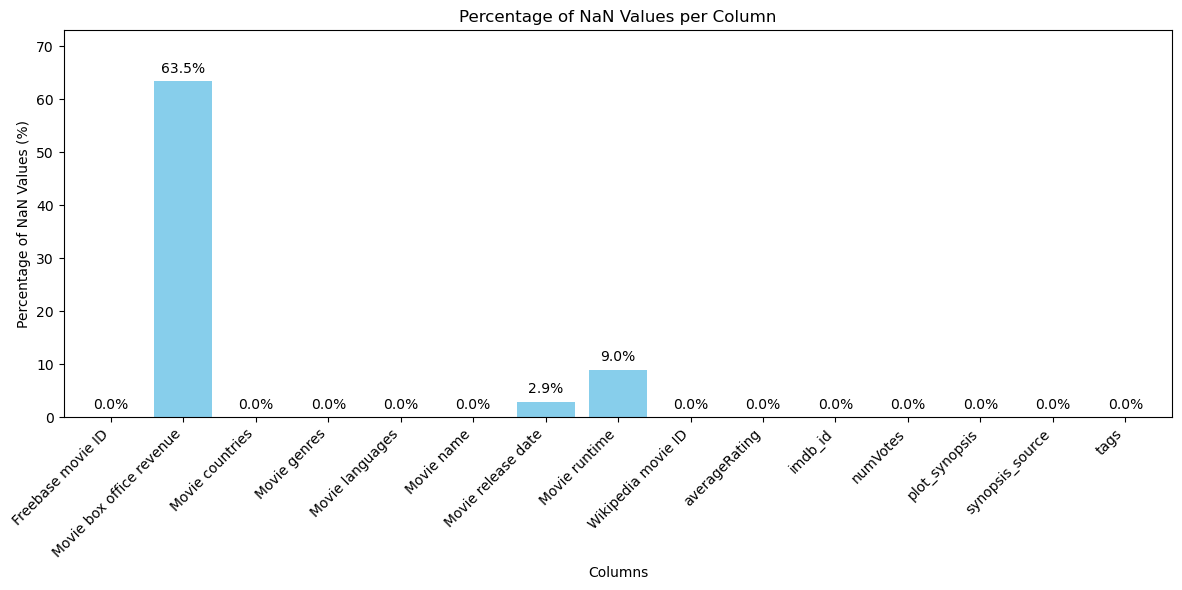

In [43]:
# Calculate percentage of NaN values in each column
na_percentage = (movies_synopsis.isna().sum() / len(movies_synopsis)) * 100
na_percentage = na_percentage.sort_index()

# Plot
plt.figure(figsize=(12, 6))
bars = na_percentage.plot(kind='bar', color='skyblue', width=0.8)  

# Add percentage labels on top of each bar
for i, value in enumerate(na_percentage):
    plt.text(i, value + 1, f'{value:.1f}%', ha='center', va='bottom', fontsize=10)  

plt.xlabel('Columns')
plt.xticks(rotation=45, ha='right')  
plt.ylabel('Percentage of NaN Values (%)')
plt.ylim(top =73)
plt.title('Percentage of NaN Values per Column')
plt.tight_layout()  

plt.show()


### Retrieving NaN values in box-office data
After realizing the high number of NaN values in the box-office revenue column, we decided to complete this data as much as possible with the IMDB library.

In [44]:
def clean_ids(s, pattern=' '): #remove in string a pattern
    s = str(s).replace(pattern, '')
    return s

#Get the right imdb_id by removing 'tt' in front of IDs
movies_synopsis['imdb_id'] = movies_synopsis['imdb_id'].apply(lambda x : clean_ids(x, 'tt'))

#Create a dic telling if 'Movie box office revenue' is a NaN or not
isnan_dic = movies_synopsis['Movie box office revenue'].isna()

def get_box_office(imdb_ID): #return the box-office revenue for a specific imdb_id
    ia = IMDb()
    movie = ia.get_movie(imdb_ID)
    box_office = movie.get('box office')
    if box_office and 'Cumulative Worldwide Gross' in box_office:
        box_office_num = float(re.sub(r'[^\d.]', '', box_office['Cumulative Worldwide Gross']))
        #box_office_num = float(box_office['Cumulative Worldwide Gross'].replace('$', '').replace(',', ''))
        return box_office_num
    return None  # Return None if no box office data is found


In [45]:
#Quick checks
index_case1 = 0
index_case2 = 1
index_case3 = 2
print(f"The initial box-office was {movies_synopsis.iloc[index_case1]['Movie box office revenue']}, we find with Imdb library {get_box_office(movies_synopsis.iloc[index_case1]['imdb_id'])}")
print(f"The initial box-office was {movies_synopsis.iloc[index_case2]['Movie box office revenue']}, we find with Imdb library {get_box_office(movies_synopsis.iloc[index_case2]['imdb_id'])}")
print(f"The initial box-office was {movies_synopsis.iloc[index_case3]['Movie box office revenue']}, we find with Imdb library {get_box_office(movies_synopsis.iloc[index_case3]['imdb_id'])}")

The initial box-office was nan, we find with Imdb library None
The initial box-office was nan, we find with Imdb library 380000.0
The initial box-office was 106269971.0, we find with Imdb library 106269971.0


We are indeed getting more box-office data, and recovering the same value in cases where we already had data ! Let's now apply the function on the whole dataset.

In [46]:
#Apply on the whole dataset
run = False #Run is very long, directly use the file in Data directory
if run:
    box_offices = movies_synopsis.apply(lambda x: get_box_office(x['imdb_id']) if isnan_dic[x.name] else x['Movie box office revenue'], axis=1) #Try to get the box-office from Imdb only if we don't already have it
    movies_synopsis.insert(len(movies_synopsis.columns), 'IMDB Box-office', box_offices)

In [49]:
movies_synopsis_comp = movies_synopsis.copy()

In [50]:
#Here is the file with completed box-office from Imdb (last column)
movies_synopsis_comp = pd.read_csv('Data/movies_synopsis_comp.csv')
display(movies_synopsis_comp.head())

FileNotFoundError: [Errno 2] No such file or directory: 'Data/movies_synopsis_comp.csv'

### Comment

We completed some of the missing data, but how much did we improve ?

In [51]:
#Improvement in NaN values in box-office
na_percentage_box_init = (movies_synopsis_comp['Movie box office revenue'].isna().sum() / len(movies_synopsis_comp)) * 100
na_percentage_box_imdb = (movies_synopsis_comp['IMDB Box-office'].isna().sum() / len(movies_synopsis_comp)) * 100
print(f"We went from {round(na_percentage_box_init,2)}% of NaN values to {round(na_percentage_box_imdb,2)}%.")

KeyError: 'IMDB Box-office'

In [ ]:
#Remove the old revenue column as we don't need it anymore
movies_synopsis_comp.drop('Movie box office revenue', axis=1, inplace=True)

### Comment
The increase is a bit deceiving. The IMDB library is missing a lot of box-offices too. We suspect the IMDB library to mabe block when there are too many requests, giving more NaN values than there actually are. In the end that's still an increase of 24% in box-office data size, which will help us for our analysis.

### Now that we have the final dataset, let's continue the analysis

In [52]:
movies_df = movies_synopsis_comp.copy()

In [53]:
import ast
def convert_to_list(df, column_name):
    #Convert to dictionnary 
    df[column_name] = df[column_name].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    #Convert to list
    df[column_name] = df[column_name].apply(lambda x: list(x.values()) if isinstance(x, dict) else None)
    return df[column_name]

In [54]:
movies_df['Movie genres'] = convert_to_list(movies_df, 'Movie genres')
movies_df['Movie languages'] = convert_to_list(movies_df, 'Movie languages')
movies_df['Movie countries'] = convert_to_list(movies_df, 'Movie countries')

In [55]:
movies_df.head()

,imdb_id,plot_synopsis,tags,synopsis_source,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,averageRating,numVotes
0,1733125,"Two thousand years ago, Nhagruul the Foul, a s...",violence,imdb,30855958,/m/0gfjl1f,Dungeons & Dragons: The Book of Vile Darkness,2012-08-09,NaN,90.0,[],[United Kingdom],[Fantasy],4.4,2722
1,0033045,"Matuschek's, a gift store in Budapest, is the ...",romantic,imdb,76353,/m/0k4bt,The Shop Around the Corner,1940-01-12,NaN,98.0,[English Language],[United States of America],"[Romantic comedy, Workplace Comedy, Black-and-...",8.0,39420
2,0113862,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",imdb,171076,/m/016z98,Mr. Holland's Opus,1995-12-29,106269971.0,130.0,"[English Language, American Sign Language]",[United States of America],"[Inspirational Drama, Family Film, Drama, Musi...",7.3,42244
3,0086250,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",imdb,76331,/m/0k44g,Scarface,1932,NaN,94.0,"[Italian Language, English Language]",[United States of America],"[Crime Fiction, Gangster Film, Black-and-white...",8.3,939605
4,0086250,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",imdb,267848,/m/01nln3,Scarface,1983-12-01,65884703.0,170.0,"[English Language, Spanish Language]",[United States of America],"[Crime Fiction, Thriller, Gangster Film, Actio...",8.3,939605


For our analysis, having the full release date isn't necessary, just the year is enough. Therefore, we convert the release date into a year format (e.g. 1995-07-21 becomes 1995).

In [56]:
def extract_year(value):
    # Check if the value is a year (4-digit number) and return it as is
    if isinstance(value, int) or (isinstance(value, str) and value.isdigit() and len(value) == 4):
        return int(value)
    # Try to convert complete date strings to datetime and extract the year
    try:
        return pd.to_datetime(value).year
    except (ValueError, TypeError):
        return np.nan  # Return NaN if conversion fails

movies_df['Movie release date'] = movies_df['Movie release date'].apply(extract_year).astype('Int64')

print(movies_df['Movie release date'].head())

0    2012
1    1940
2    1995
3    1932
4    1983
Name: Movie release date, dtype: Int64


We remove rows where the release date is missing, which, as shown in the previous graph, accounts for 3% of the total data. After removing these rows, we verify that the operation was successful.

In [57]:
# Remove the years that are NaN as we are intereseted in the release years
print(movies_df['Movie release date'].isna().value_counts())
movies_df_cleaned = movies_df.dropna(subset=['Movie release date'])

movies_df_cleaned['Movie release date'].isna().any()


False    14253
True       433
Name: Movie release date, dtype: int64


False

### Movies languages exploration

In [58]:
all_languages = movies_df_cleaned['Movie languages'].explode()

language_counts = all_languages.value_counts()

print(language_counts)

English Language           11712
French Language              755
Spanish Language             531
Hindi Language               505
German Language              414
                           ...  
Hmong language                 1
Azerbaijani language           1
Malay Language                 1
Farsi, Western Language        1
Southwestern Mandarin          1
Name: Movie languages, Length: 148, dtype: int64


In [59]:
num_unique_languages = all_languages.nunique()
print("The dataset contains ", num_unique_languages, "unique languages.")

The dataset contains  148 unique languages.


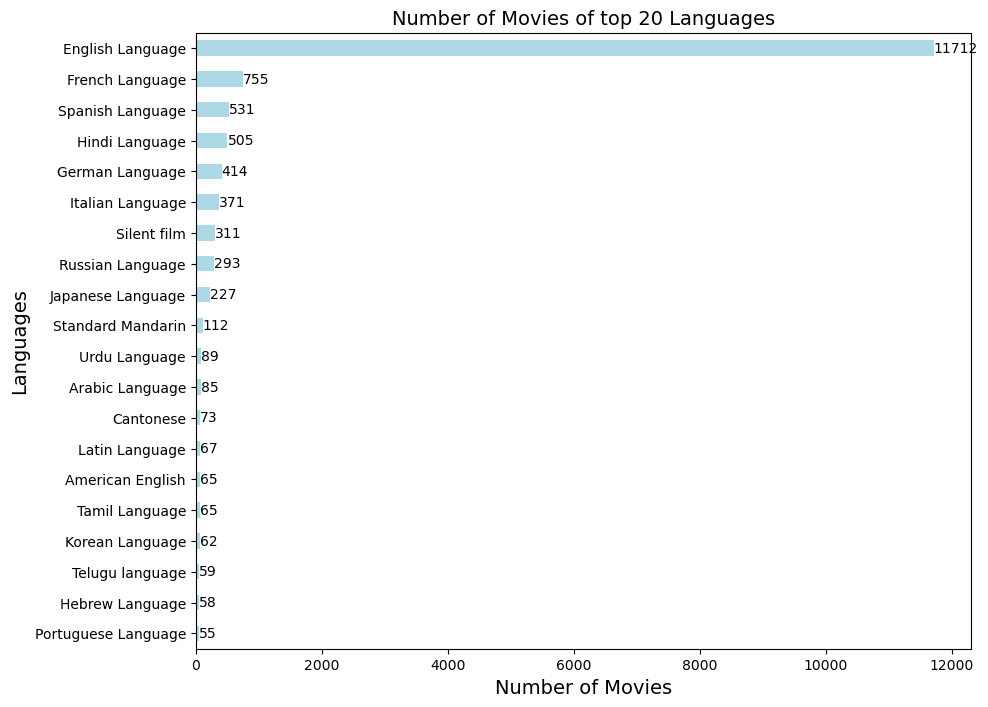

In [60]:
# Plot the number of movies per language 
plt.figure(figsize=(10, 8))
bars = language_counts.head(20).sort_values(ascending=True).plot(kind='barh', color='lightblue')

for index, value in enumerate(language_counts.head(20).sort_values(ascending=True)):
    plt.text(value, index, str(value), va='center')

plt.xlabel('Number of Movies',fontsize=14)
plt.ylabel('Languages',fontsize=14)
plt.title('Number of Movies of top 20 Languages', fontsize=14)

plt.show()

As previously seen, English is largely dominant. This can be attributed to its role as a global lingua franca, making films more accessible to international audiences. Additionally, major movie industries in countries like the United Kingdom and other English-speaking regions contribute to the high number of English-language films.

For better visibility, we chose to display only the top 20 languages in this chart. It is also noticeable that the number of movies per language drops off quickly after the most common languages, highlighting the dominance of a few major languages in movie production and a long tail of less commonly represented languages.

### Movies' genres exploration

In [61]:
all_genres = movies_df_cleaned['Movie genres'].explode()

genres_counts = all_genres.value_counts()

num_unique_genre = all_genres.nunique()
print("Number of unique genres:", num_unique_genre)

Number of unique genres: 333


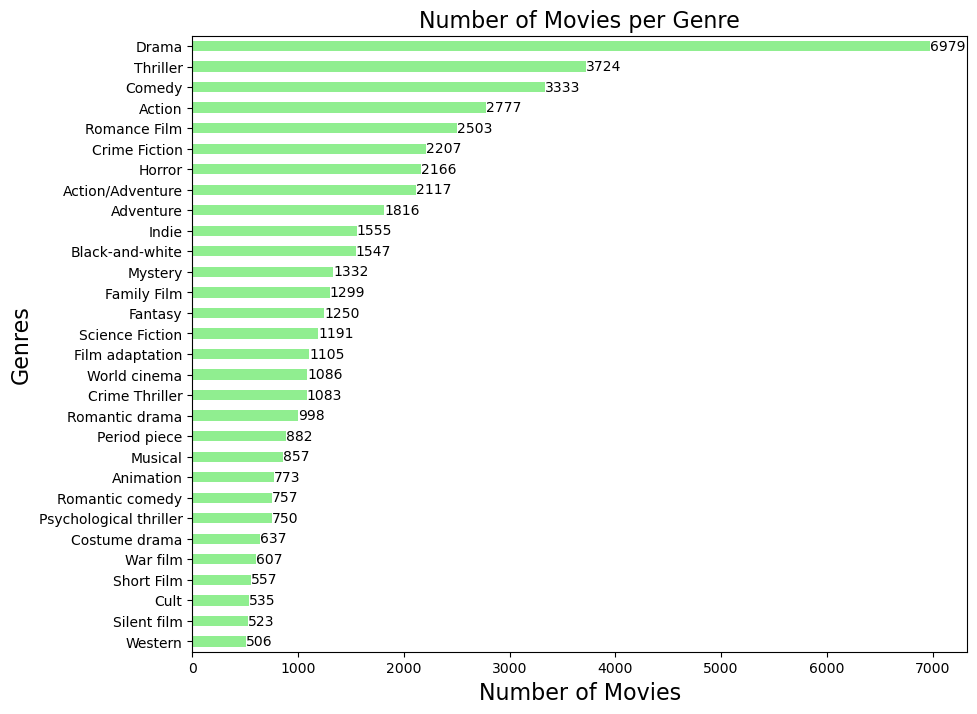

In [62]:
# Plot the number of movies per top 30 genres
plt.figure(figsize=(10, 8))
bars = genres_counts.head(30).sort_values(ascending=True).plot(kind='barh', color='lightgreen')

for index, value in enumerate(genres_counts.head(30).sort_values(ascending=True)):
    plt.text(value, index, str(value), va='center')

plt.xlabel('Number of Movies', fontsize=16)
plt.ylabel('Genres', fontsize=16)
plt.title('Number of Movies per Genre', fontsize=16)  

plt.show()

Drama is the clear leader when it comes to movie genres, followed by Comedy and Romance. This makes sense since these genres appeal to a wide range of audiences. Genres like Thriller, Action, and Documentary are also popular, showing that people enjoy excitement and real-life stories. On the other end, niche genres like 'Cult' and 'Political drama' are much less common, which isn't surprising given their more specific audience.

Here we decided to show only the top 30 genres to keep the chart clear and easy to read.

### Movies' countries exploration

Here we analyse in which countries most films are released, and whether this change based on the years.

In [63]:
all_countries = movies_df_cleaned['Movie countries'].explode()

countries_counts = all_countries.value_counts() 

print(countries_counts)

United States of America    10205
United Kingdom               2268
France                        757
Germany                       650
India                         647
                            ...  
Mandatory Palestine             1
Kenya                           1
Sri Lanka                       1
Serbia and Montenegro           1
Mongolia                        1
Name: Movie countries, Length: 109, dtype: int64


In [64]:
num_unique_countries = all_countries.nunique()
print("Number of unique countries:", num_unique_countries)

Number of unique countries: 109


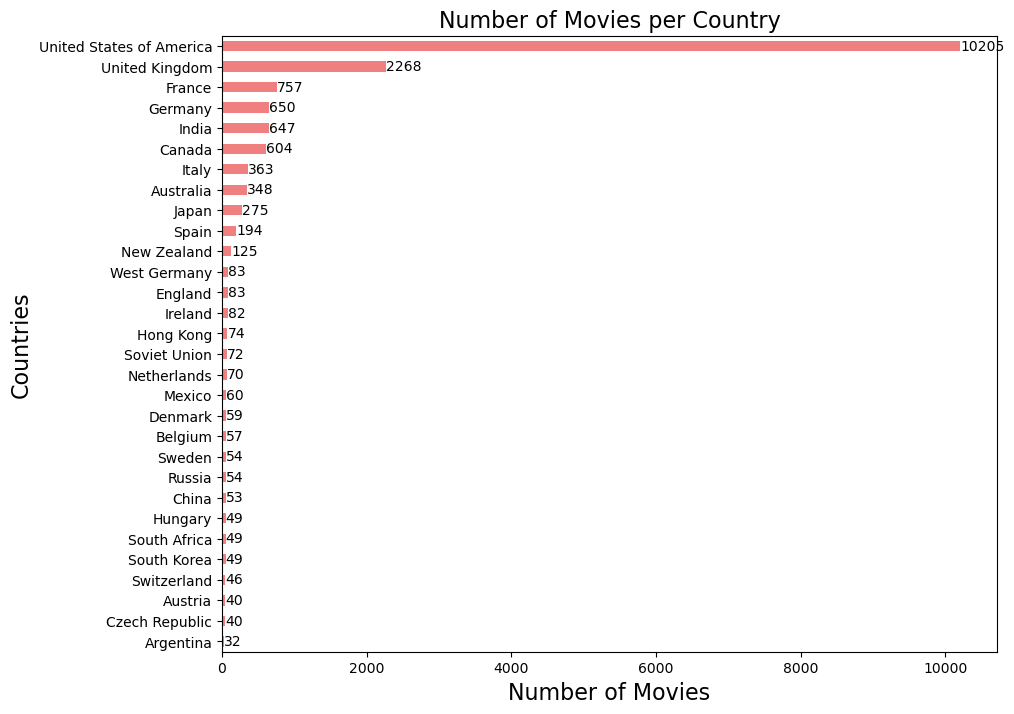

In [65]:
# Plot the number of movies per top 30 country
plt.figure(figsize=(10, 8))
bars = countries_counts.head(30).sort_values(ascending=True).plot(kind='barh', color='lightcoral')

for index, value in enumerate(countries_counts.head(30).sort_values(ascending=True)):
    plt.text(value, index, str(value), va='center')

plt.xlabel('Number of Movies', fontsize=16)
plt.ylabel('Countries', fontsize=16)
plt.title('Number of Movies per Country', fontsize=16)  

plt.show()

The United States has the most movies by far, showing its huge impact on the film industry. The United Kingdoms and France come next, thanks to Bollywood and British cinema. Germany, India and Canada also produce a lot of movies. The numbers drop as you go down the list, with fewer movies made in other countries.

Once again we decided to show only the top 30 countries to keep the chart clear and easy to read.

### Movies release year exploration

Here we do a general analysis about the total number of movies released each year.

In [66]:
all_years = movies_df_cleaned['Movie release date'].explode()

years_counts = all_years.value_counts()

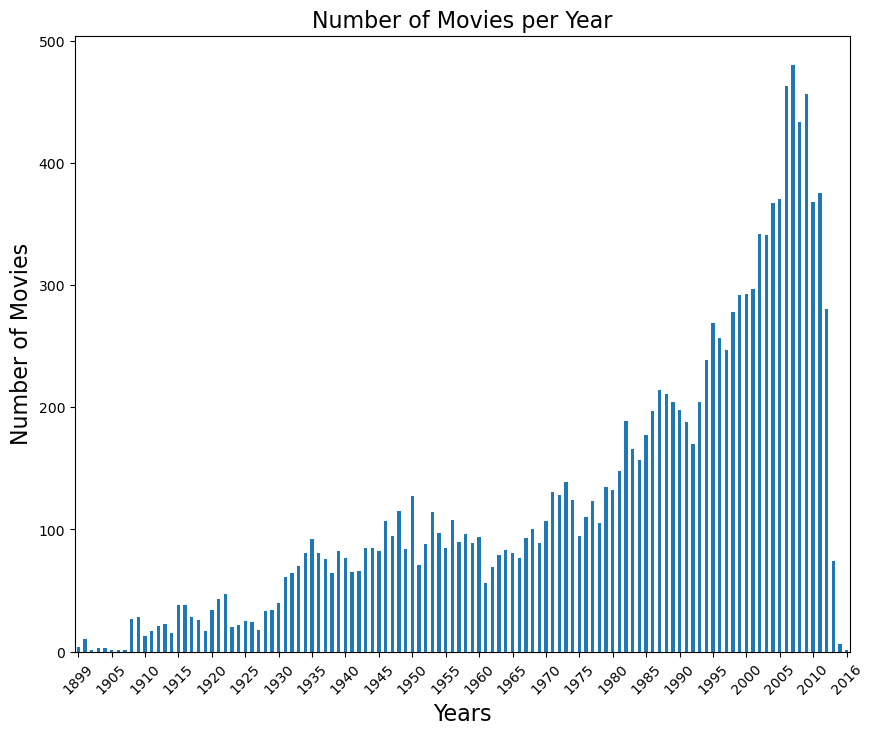

In [67]:
plt.figure(figsize=(10, 8))  
plot_years_counts = all_years.value_counts().sort_index().plot(kind='bar')
plt.xlabel('Years', fontsize=16 )
plt.ylabel('Number of Movies', fontsize=16)
plt.title('Number of Movies per Year', fontsize=16)

plt.xticks(range(0, len(all_years.value_counts().sort_index()), 5), 
           all_years.value_counts().sort_index().index[::5], 
           rotation=45)

plt.show()

The movie production has grown steadily over time, with a big jump starting in the 1990s and peaking in the early 2000s. The increase after the 1980s is likely due to better technology and more people making movies around the world. The early years have fewer movies because the film industry was just getting started.

### Movies per year for most important countries

Now we go a bit deeper and we analyze in which countries most of the movies are released each year.

In [68]:
# Get top 10 countries releasing movies
top_10_countries = countries_counts.head(10).index

# Get one country per row (since some movies contain more that one countries)
expanded_df = movies_df_cleaned.explode('Movie countries')

top_countries_df = expanded_df[expanded_df['Movie countries'].isin(top_10_countries)]

In [69]:
# Count movies per year for each country
movies_per_year_countries = top_countries_df.groupby(['Movie countries', 'Movie release date']).size().unstack(fill_value=0)

In [76]:
import plotly.graph_objects as go
# Create the interactive figure
fig = go.Figure()

for country in movies_per_decade_countries.columns:
    fig.add_trace(go.Bar(
        x=movies_per_decade_countries.index,  # Decades
        y=movies_per_decade_countries[country],  # Number of movies
        name=country,
        hovertemplate='Percentage: %{customdata:.2f}%',
        customdata=100 * movies_per_decade_countries[country] / movies_per_decade_countries.sum(axis=1)
    ))

# Update layout for better visual appeal
fig.update_layout(
    title='Proportion of Movies Produced by Top 10 Countries per Decade',
    xaxis_title='Decade',
    yaxis_title='Number of Movies',
    barmode='stack',
    legend_title='Country',
    hovermode='x'
)

# Show the figure
fig.show()


The United States has consistently produced the most movies over time, with a sharp increase from the 1970s and peaking in the early 2000s. The UK follows as the second-highest producer, with a growth around 1990. Other countries like France, Germany and India show steady but much smaller production levels. The graph highlights the dominance of the U.S. and UK in global movie production.

For the next part of the analysis, we group the data by decade to see clearer trends and changes in movie production over time.

### Do the genres of the released movies vary on different decades?

We analyze now how the genres of movies change with respect to the years.

In [77]:
# Get top 10 countries releasing movies
top_10_genres = genres_counts.head(10).index
top_20_genres = genres_counts.head(20).index

# Get one country per row
expanded_df_genre = movies_df_cleaned.explode('Movie genres')

# the top 10
top_genres_df_10 = expanded_df_genre[expanded_df_genre['Movie genres'].isin(top_10_genres)]

movies_per_year_genres_10 = top_genres_df_10.groupby(['Movie genres', 'Movie release date']).size().unstack(fill_value=0)
movies_per_decade_genres_10 = movies_per_year_genres_10.groupby((movies_per_year_genres_10.columns // 10) * 10, axis=1).sum()

# the top 20
top_genres_df_20 = expanded_df_genre[expanded_df_genre['Movie genres'].isin(top_20_genres)]

movies_per_year_genres_20 = top_genres_df_20.groupby(['Movie genres', 'Movie release date']).size().unstack(fill_value=0)
movies_per_decade_genres_20 = movies_per_year_genres_20.groupby((movies_per_year_genres_20.columns // 10) * 10, axis=1).sum()

movies_per_decade_genres_20_percentage = movies_per_decade_genres_20.div(movies_per_decade_genres_20.sum(axis=1), axis=0)

This plot shows that drama, thriller and comedy are the top 3 most popular genres. Overall, every genre increases with time.

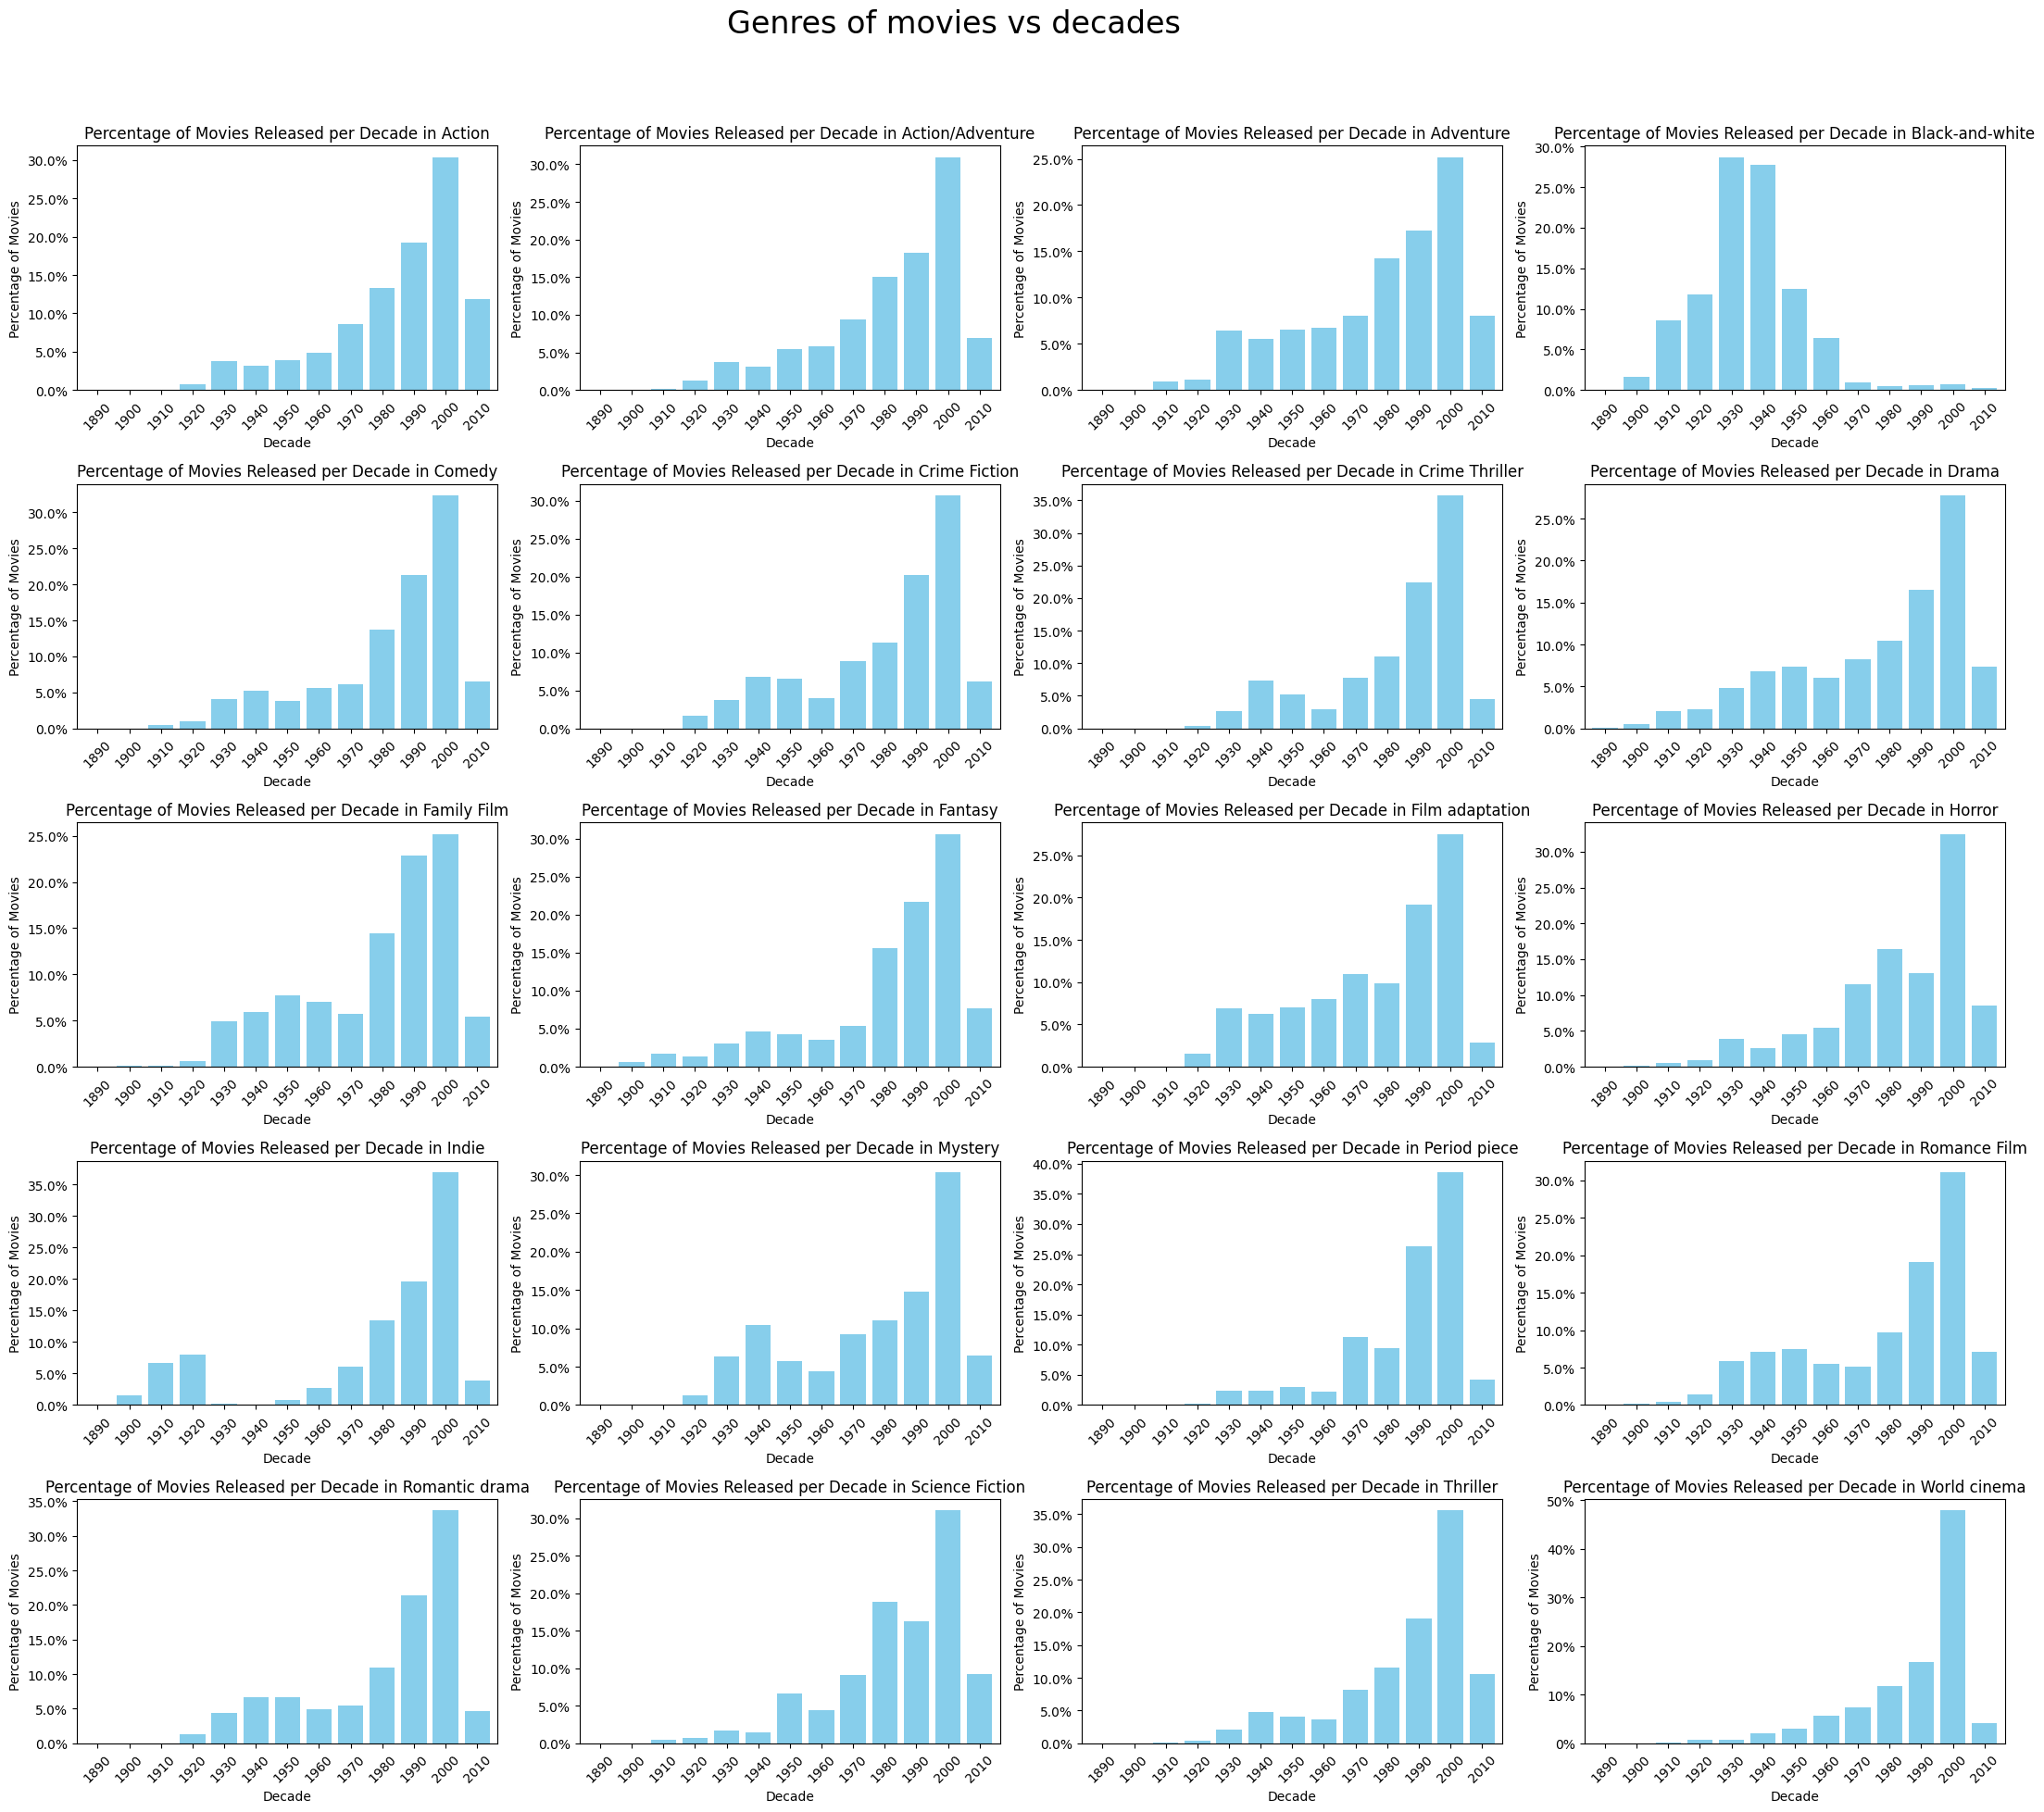

In [69]:
# Plot a bar chart for each genre in years
n_rows, n_cols = 5, 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(23, 21))  # Create a 5x4 grid of subplots
fig.suptitle('Genres of movies vs decades', fontsize=24)
axes = axes.flatten()

# Loop through each genre and plot the data
for i, genre in enumerate(movies_per_decade_genres_20_percentage.index):
    ax = axes[i]
    
    # Plot the bar chart for the current genre
    movies_per_decade_genres_20_percentage.loc[genre].plot(kind='bar', color='skyblue', width=0.8, ax=ax)

    ax.set_xlabel('Decade')
    ax.set_ylabel('Percentage of Movies')
    ax.set_title(f'Percentage of Movies Released per Decade in {genre}')
    ax.tick_params(axis='x', rotation=45)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
plt.show()

These plots show that drama, comedy, and documentary movies have steadily increased over time, peaking in the 2000s. Genres like black-and-white and silent films were popular in the early 20th century but declined afterward. More action, horror, and thriller movies have emerged in recent decades, reflecting changing audience preferences. Overall, the data indicates a shift towards more diverse genres over time, with significant growth in certain types of films in the latter half of the 20th century and beyond.

In [82]:
import plotly.graph_objects as go
import pandas as pd
movies_per_decade_by_genre = movies_per_decade_genres_10.T

# Ensure your DataFrame `movies_per_decade_by_genre_normalized` is defined and normalized
movies_per_decade_by_genre_normalized = movies_per_decade_by_genre.div(movies_per_decade_by_genre.sum(axis=1), axis=0)

# Create an interactive figure
fig = go.Figure()

# Iterate through each decade and create a bar plot for it
for decade in movies_per_decade_by_genre_normalized.index:
    fig.add_trace(go.Bar(
        x=movies_per_decade_by_genre_normalized.columns,
        y=movies_per_decade_by_genre_normalized.loc[decade],  # Convert to percentage
        name=f'{decade}s',
        visible=False  # Initially set all traces to invisible
    ))

# Set the first decade to be visible
fig.data[0].visible = True

# Create the slider steps
steps = []
for i, decade in enumerate(movies_per_decade_by_genre_normalized.index):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)}],  # Hide all traces
        label=f"{decade}s"
    )
    step["args"][0]["visible"][i] = True  # Set the current decade's trace to visible
    steps.append(step)

# Create slider
sliders = [dict(
    active=0,
    currentvalue={"prefix": "Decade: "},
    pad={"t": 50},
    steps=steps
)]

# Update the layout to include the slider
fig.update_layout(
    sliders=sliders,
    title='Proportion of Movies Released by Genre in Each Decade',
    xaxis_title='Genre',
    yaxis_title='Percentage of Movies',
    yaxis=dict(tickformat=".1%"),
    barmode='group'
)

# Show the plot
fig.show()


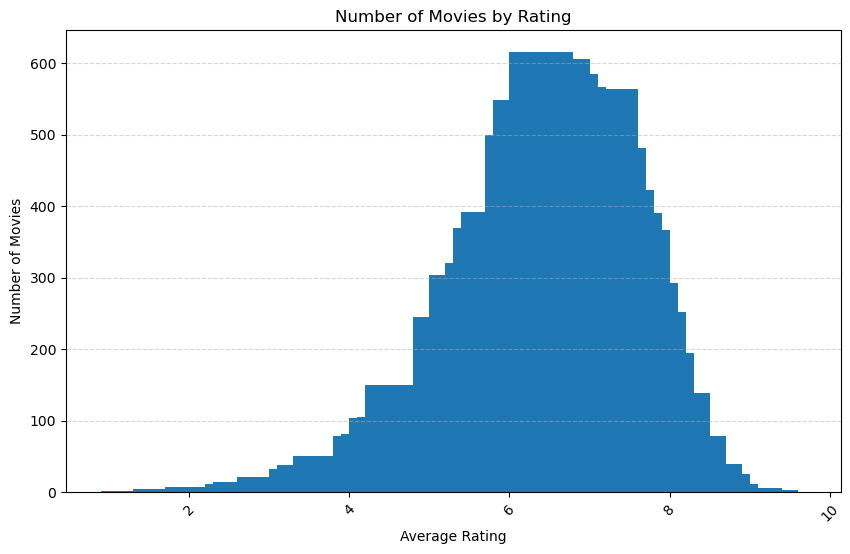

In [83]:
import matplotlib.pyplot as plt
rating_counts = movies_df_cleaned['averageRating'].value_counts().sort_index()

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(rating_counts.index, rating_counts.values)
plt.xlabel('Average Rating')
plt.ylabel('Number of Movies')
plt.title('Number of Movies by Rating')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# Part 3: Analysis of the historical dataset